In [ ]:
import yfinance as f

##VERONICA


##GRU Implementation

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = yf.download("GBPUSD=X", start="2000-01-01")
df = df[['Open','High','Low','Close']]
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df.copy()
df.index = pd.to_datetime(df.index)

## Rolling Statistics

**Mean Return (w-day window):**
$$
\text{mean_ret}_t^{(w)} = \frac{1}{w} \sum_{i=0}^{w-1} \text{ret}_{t-i}
$$

**Standard Deviation of Returns:**
$$
\text{std_ret}_t^{(w)} = \sqrt{\frac{1}{w} \sum_{i=0}^{w-1} \left( \text{ret}_{t-i} - \text{mean\_ret}_t^{(w)} \right)^2}
$$

## ATR (Average True Range)

**True Range:**
$$
TR_t = \max\left(H_t - L_t,\; |H_t - C_{t-1}|,\; |L_t - C_{t-1}|\right)
$$

**Average True Range:**
$$
ATR_t^{(w)} = \frac{1}{w} \sum_{i=0}^{w-1} TR_{t-i}
$$

## RSI (Relative Strength Index)

**Price difference:**
$$
\Delta_t = C_t - C_{t-1}
$$

**Upside move:**
$$
\text{up}_t = \max(\Delta_t, 0)
$$

**Downside move:**
$$
\text{down}_t = \max(-\Delta_t, 0)
$$

**Exponential moving averages (period = 14):**
$$
EMA_t^{up} = EMA(\text{up}_t, 14)
$$
$$
EMA_t^{down} = EMA(\text{down}_t, 14)
$$

**Relative Strength:**
$$
RS_t = \frac{EMA_t^{up}}{EMA_t^{down}}
$$

**RSI:**
$$
RSI_t = 100 - \frac{100}{1 + RS_t}
$$

In [ ]:
DELTA = 0.005
df['target'] = (df['High'] >= (1 + DELTA) * df['Open']).astype(int)

df['log_ret'] = np.log(df['Close']).diff() #compounded price change over time
df['ret'] = df['Close'].pct_change() #percent return
df['hl_range'] = (df['High'] - df['Low']) / df['Open'] #Daily Voltility
df['oc_range'] = (df['Close'] - df['Open']) / df['Open'] #Open Close Range (Direction + Strength)
df['high_open'] = (df['High'] - df['Open']) / df['Open'] #Intraday Upside
df['low_open'] = (df['Low'] - df['Open']) / df['Open'] #Low Open Intraday Upside

# Rolling stats
for w in [5, 10, 20]:
    df[f'mean_ret_{w}'] = df['ret'].rolling(w).mean() #average return in w days
    df[f'std_ret_{w}'] = df['ret'].rolling(w).std()
    df[f'vol_{w}'] = df['ret'].rolling(w).std()

# ATR (true daily volatility)
for col in ["Open", "High", "Low", "Close"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["prev_close"] = df["Close"].shift(1)

tr1 = (df["High"] - df["Low"]).astype(float).to_numpy()
tr2 = (df["High"] - df["prev_close"]).abs().astype(float).to_numpy()
tr3 = (df["Low"] - df["prev_close"]).abs().astype(float).to_numpy()

df["tr"] = np.maximum.reduce([tr1, tr2, tr3])

for w in [2, 5, 8]:
    df[f'ATR_{w}'] = df['tr'].rolling(w).mean() / df['Open']

# RSI (overheated vs oversold states)
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
ema_up = up.ewm(alpha=1/14, adjust=False).mean()
ema_down = down.ewm(alpha=1/14, adjust=False).mean()
rs = ema_up / (ema_down + 1e-10)
df['RSI_14'] = 100 - 100 / (1 + rs)

df['volatility_ratio'] = df['std_ret_10'] / (df['std_ret_20'] + 1e-9)
df['momentum_5'] = df['Close'] / df['Close'].shift(5) - 1

df = df.dropna().copy()

In [ ]:
feature_cols = [
    'Open','High','Low','Close',
    'log_ret','ret',
    'hl_range','oc_range','high_open','low_open',
    'mean_ret_5','std_ret_5','mean_ret_10','std_ret_10','vol_20',
    'ATR_5','ATR_14','ATR_20',
    'RSI_14','volatility_ratio','momentum_5'
]
feature_cols = [c for c in feature_cols if c in df.columns]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[feature_cols].values)

def build_sequences(X_array, y_array, timesteps):
    Xs, ys = [], []
    for i in range(timesteps, len(X_array)):
        Xs.append(X_array[i - timesteps:i])
        ys.append(y_array[i])
    return np.array(Xs), np.array(ys)


In [ ]:
y = df['target'].values
param_grid = {
    'timesteps': [10, 15, 30],
    'gru_units': [32, 64],
    'dropout': [0.1, 0.2],
    'batch_size': [32, 64]
}
def build_gru_model(timesteps, n_features, gru_units=64, dropout=0.2):
    m = Sequential()
    m.add(GRU(gru_units, return_sequences=False, input_shape=(timesteps, n_features)))
    m.add(BatchNormalization())
    m.add(Dropout(dropout))
    m.add(Dense(int(gru_units/2), activation='relu'))
    m.add(Dense(1, activation='sigmoid'))
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return m

best = {'val_auc': -np.inf}

In [ ]:
for timesteps in param_grid['timesteps']:
    X_seq, y_seq = build_sequences(data_scaled, y, timesteps)
    # time-based train/val/test split: 70/15/15
    n = len(X_seq)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)
    X_train, X_val, X_test = X_seq[:train_end], X_seq[train_end:val_end], X_seq[val_end:]
    y_train, y_val, y_test = y_seq[:train_end], y_seq[train_end:val_end], y_seq[val_end:]

    # compute class weights to handle imbalance
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = {c: w for c, w in zip(classes, class_weights)}

    for gru_units in param_grid['gru_units']:
        for dropout in param_grid['dropout']:
            for batch_size in param_grid['batch_size']:
                tf.keras.backend.clear_session()
                model = build_gru_model(timesteps, X_train.shape[2],
                                        gru_units=gru_units, dropout=dropout)
                # callbacks
                es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
                rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0)
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=80,
                    batch_size=batch_size,
                    class_weight=class_weight_dict,
                    callbacks=[es, rl],
                    verbose=0
                )
                # predict on validation set
                val_probs = model.predict(X_val, batch_size=1024).ravel()
                try:
                    val_auc = roc_auc_score(y_val, val_probs)
                except ValueError:
                    val_auc = 0.5
                val_preds = (val_probs > 0.5).astype(int)
                val_acc = accuracy_score(y_val, val_preds)
                # store best
                if val_auc > best['val_auc']:
                    best.update({
                        'val_auc': val_auc,
                        'timesteps': timesteps,
                        'gru_units': gru_units,
                        'dropout': dropout,
                        'batch_size': batch_size,
                        'model': model,
                        'history': history,  # <-- add this
                        'X_test': X_test, 'y_test': y_test,
                        'X_val': X_val, 'y_val': y_val,
                        'X_train': X_train, 'y_train': y_train
                    })

                print(f"ts={timesteps:2d},units={gru_units},drop={dropout},bs={batch_size} -> val_auc={val_auc:.4f}, val_acc={val_acc:.4f}")

history = best['history']  # only works if you saved the last history object in 'best'

# Extract metrics
epochs = range(1, len(history.history['loss']) + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(2,2,2)
plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)


plt.tight_layout()
plt.show()


In [ ]:
print("\nBEST CONFIG (by val AUC):", best['timesteps'], best['gru_units'], best['dropout'], best['batch_size'], "val_auc=", best['val_auc'])
best_model = best['model']
X_test = best['X_test']; y_test = best['y_test']

test_probs = best_model.predict(X_test, batch_size=1024).ravel()
test_preds = (test_probs > 0.5).astype(int)

test_acc = accuracy_score(y_test, test_preds)
test_prec = precision_score(y_test, test_preds, zero_division=0)
test_rec = recall_score(y_test, test_preds, zero_division=0)
test_f1 = f1_score(y_test, test_preds, zero_division=0)
test_auc = roc_auc_score(y_test, test_probs)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")

#print first 10 probs/preds
print("Example test probs (first 10):", np.round(test_probs[:10],4))
print("Example preds :", test_preds[:10])

In [ ]:
probs = model.predict(X_test)
signals = (probs > 0.5).astype(int)

print("First 10 probabilities:", probs[:10].ravel())

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
summary = pd.DataFrame({
    "Metric" : ["AUC", "Accuracy", "Precision", "Recall", "F1"],
    "Value"  : [test_auc, test_acc, test_prec, test_rec, test_f1]
})

summary.style.format({"Value": "{:.4f}"})


In [ ]:
thresholds = np.linspace(0,1,101)
accuracies = []

for t in thresholds:
    preds_t = (test_probs > t).astype(int)
    acc = (preds_t == y_test).mean()
    accuracies.append(acc)

plt.figure(figsize=(6,4))
plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Decision Thresholds")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
labels = ["No", "Yes"]
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Proportion", rotation=-90, va="bottom")

ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel="Actual",
    xlabel="Predicted",
    title="Confusion Matrix – GRU Model"
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            f"{cm[i, j]}\n({cm_norm[i, j]:.2%})",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black"
        )

plt.tight_layout()
plt.show()


####Adding Attention to GRU

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        u_it = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)  # (batch, timesteps, features)
        a_it = tf.nn.softmax(tf.tensordot(u_it, self.u, axes=1), axis=1)  # (batch, timesteps, 1)
        output = tf.reduce_sum(inputs * a_it, axis=1)  # (batch, features)
        return output


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, BatchNormalization

def build_gru_with_attention(timesteps, n_features, gru_units=64, dropout=0.2):
    inputs = Input(shape=(timesteps, n_features))
    x = GRU(gru_units, return_sequences=True)(inputs)  # return_sequences=True needed for attention
    x = Attention()(x)  # attention layer
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    x = Dense(int(gru_units/2), activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
for timesteps in param_grid['timesteps']:
    X_seq, y_seq = build_sequences(data_scaled, y, timesteps)
    # time-based train/val/test split: 70/15/15
    n = len(X_seq)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)
    X_train, X_val, X_test = X_seq[:train_end], X_seq[train_end:val_end], X_seq[val_end:]
    y_train, y_val, y_test = y_seq[:train_end], y_seq[train_end:val_end], y_seq[val_end:]

    # compute class weights to handle imbalance
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = {c: w for c, w in zip(classes, class_weights)}

    for gru_units in param_grid['gru_units']:
        for dropout in param_grid['dropout']:
            for batch_size in param_grid['batch_size']:
                tf.keras.backend.clear_session()
                model = build_gru_with_attention(timesteps, X_train.shape[2],
                                        gru_units=gru_units, dropout=dropout)
                # callbacks
                es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=0)
                rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0)
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=80,
                    batch_size=batch_size,
                    class_weight=class_weight_dict,
                    callbacks=[es, rl],
                    verbose=0
                )
                # predict on validation set
                val_probs = model.predict(X_val, batch_size=1024).ravel()
                try:
                    val_auc = roc_auc_score(y_val, val_probs)
                except ValueError:
                    val_auc = 0.5
                val_preds = (val_probs > 0.5).astype(int)
                val_acc = accuracy_score(y_val, val_preds)
                # store best
                if val_auc > best['val_auc']:
                    best.update({
                        'val_auc': val_auc,
                        'timesteps': timesteps,
                        'gru_units': gru_units,
                        'dropout': dropout,
                        'batch_size': batch_size,
                        'model': model,
                        'history': history,  # <-- add this
                        'X_test': X_test, 'y_test': y_test,
                        'X_val': X_val, 'y_val': y_val,
                        'X_train': X_train, 'y_train': y_train
                    })

                print(f"ts={timesteps:2d},units={gru_units},drop={dropout},bs={batch_size} -> val_auc={val_auc:.4f}, val_acc={val_acc:.4f}")

history = best['history']  # only works if you saved the last history object in 'best'

# Extract metrics
epochs = range(1, len(history.history['loss']) + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Here we'll just plot loss and accuracy
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'r-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

plt.subplot(2,2,2)
plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)


plt.tight_layout()
plt.show()


In [ ]:
print("\nBEST CONFIG (by val AUC):")
print(f"Timesteps: {best['timesteps']}, GRU Units: {best['gru_units']}, Dropout: {best['dropout']}, Batch Size: {best['batch_size']}, Val AUC: {best['val_auc']:.4f}")

best_model = best['history'].model  # The model is stored inside the MetricsCallback
X_test = best['X_test'] if 'X_test' in best else X_val  # fallback
y_test = best['y_test'] if 'y_test' in best else y_val

# Predict on test set
test_probs = best_model.predict(X_test, batch_size=1024).ravel()
test_preds = (test_probs > 0.5).astype(int)

# Test metrics
test_acc = accuracy_score(y_test, test_preds)
test_prec = precision_score(y_test, test_preds, zero_division=0)
test_rec = recall_score(y_test, test_preds, zero_division=0)
test_f1 = f1_score(y_test, test_preds, zero_division=0)
test_auc = roc_auc_score(y_test, test_probs)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")

# Example: print first 10 probs/preds
print("Example test probs (first 10):", np.round(test_probs[:10],4))
print("Example preds (first 10):", test_preds[:10])


In [ ]:
probs = model.predict(X_test)
signals = (probs > 0.5).astype(int)

print("First 10 probabilities:", probs[:10].ravel())

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

summary = pd.DataFrame({
    "Metric" : ["AUC", "Accuracy", "Precision", "Recall", "F1"],
    "Value"  : [test_auc, test_acc, test_prec, test_rec, test_f1]
})

summary.style.format({"Value": "{:.4f}"})


In [ ]:
thresholds = np.linspace(0,1,101)
accuracies = []

for t in thresholds:
    preds_t = (test_probs > t).astype(int)
    acc = (preds_t == y_test).mean()
    accuracies.append(acc)

plt.figure(figsize=(6,4))
plt.plot(thresholds, accuracies)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy Across Decision Thresholds with Attention")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)
labels = ["No", "Yes"]
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Proportion", rotation=-90, va="bottom")

ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    ylabel="Actual",
    xlabel="Predicted",
    title="Confusion Matrix – GRU Model"
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            f"{cm[i, j]}\n({cm_norm[i, j]:.2%})",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black"
        )

plt.tight_layout()
plt.show()


##DHRUTH

In [ ]:
# import yfinance as yf

# df = yf.download("GBPUSD=X", start="2000-01-01")
# df = df[['Open','High','Low','Close']]
# df

In [ ]:
# If yfinance is not installed, uncomment and run this line once:
# !pip install yfinance --upgrade

import pandas as pd
import numpy as np
import yfinance as yf

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [ ]:
# download the data

# date range
ticker = "GBPUSD=X"
start_date = "2000-01-01"
end_date = "2025-11-01"

# download daily data from Yahoo Finance
fx_df = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# relevant OHLC columns for now
fx_df = fx_df[["Open", "High", "Low", "Close"]]

print("Shape:", fx_df.shape)
print("\nHead:")
display(fx_df.head())

print("\nTail:")
display(fx_df.tail())

print("\nInfo:")
fx_df.info()

In [ ]:
# step 2: clean columns

# flatten multi-index columns
fx_df.columns = [col[0] if isinstance(col, tuple) else col for col in fx_df.columns]

print("Columns:", fx_df.columns.tolist())

# sort index to be safe
fx_df = fx_df.sort_index()

# drop duplicates
fx_df = fx_df[~fx_df.index.duplicated(keep='first')]

print("\nHead:")
display(fx_df.head())

According to the project, we need to:
- define a profit-taking level Δ (e.g., Δ = 0.005 = 0.5%)
- predict whether: High >= (1 + Δ) * Open, for tomorrow

So for day *t*, the label depends on day *t + 1*

So we can implement:

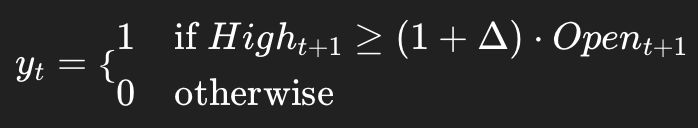

We will also shift the label back by 1 day so that it lines up with features from day *t*

Let's pick Δ = 0.005

In [ ]:
# step 3: create target variable y_t based on next day's High and Open

Δ = 0.005   # 0.5% profit target

# compute tomorrow's High and Open
fx_df['Open_tomorrow'] = fx_df['Open'].shift(-1)
fx_df['High_tomorrow'] = fx_df['High'].shift(-1)

# create target
fx_df['target'] = (fx_df['High_tomorrow'] >= (1 + Δ) * fx_df['Open_tomorrow']).astype(int)

# drop final row b/c it has no label
fx_df = fx_df.dropna(subset=['target'])

print("Target value counts:")
print(fx_df['target'].value_counts())

print("\nSample rows:")
display(fx_df[['Open','High','Open_tomorrow','High_tomorrow','target']].head(10))

In [ ]:
# step 4: feature engineering

# log return of closing price (more stable than % returns)
# log_ret_close = log(Close_t / Close_{t-1})
fx_df['log_ret_close'] = np.log(fx_df['Close'] / fx_df['Close'].shift(1))

# intraday return (close-to-open)
# (Close_t - Open_t) / Open_t
fx_df['intraday_ret'] = (fx_df['Close'] - fx_df['Open']) / fx_df['Open']

# daily range relative to open
# (High_t - Low_t) / Open_t
fx_df['range_rel'] = (fx_df['High'] - fx_df['Low']) / fx_df['Open']

# high/low normalized to previous close (helps LSTM stability)
fx_df['high_norm'] = fx_df['High'] / fx_df['Close'].shift(1)
fx_df['low_norm'] = fx_df['Low'] / fx_df['Close'].shift(1)
fx_df['open_norm'] = fx_df['Open'] / fx_df['Close'].shift(1)
fx_df['close_norm'] = fx_df['Close'] / fx_df['Close'].shift(1)

# rolling volatility (5-day window)
fx_df['volatility_5'] = fx_df['log_ret_close'].rolling(5).std()

# drop the early NaNs created by shifts/rolling windows
fx_df = fx_df.dropna()

# feature columns
feature_cols = [
    'log_ret_close', 'intraday_ret', 'range_rel',
    'high_norm', 'low_norm', 'open_norm', 'close_norm',
    'volatility_5'
]

print("Feature columns:", feature_cols)
display(fx_df[feature_cols + ['target']].head(10))

# check for any remaining NaNs
print("\nRemaining NaNs per column:")
print(fx_df.isna().sum())

In [ ]:
# step 4b: add indicator features (ATR / RSI / rolling stats / momentum) from veronica

# 1) Simple percent return (needed for rolling mean/std)
fx_df['ret'] = fx_df['Close'].pct_change()

# 2) Rolling mean/std of returns (5/10/20)
for w in [5, 10, 20]:
    fx_df[f'mean_ret_{w}'] = fx_df['ret'].rolling(w).mean()
    fx_df[f'std_ret_{w}']  = fx_df['ret'].rolling(w).std()

# 3) True Range + ATR (normalized by Open, like your teammate)
fx_df['prev_close'] = fx_df['Close'].shift(1)

tr1 = fx_df['High'] - fx_df['Low']
tr2 = (fx_df['High'] - fx_df['prev_close']).abs()
tr3 = (fx_df['Low'] - fx_df['prev_close']).abs()

fx_df['tr'] = np.maximum.reduce([tr1.values, tr2.values, tr3.values])

for w in [5, 14, 20]:
    fx_df[f'ATR_{w}'] = fx_df['tr'].rolling(w).mean() / fx_df['Open']

# 4) RSI(14) with EMA smoothing
delta = fx_df['Close'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)

ema_up = up.ewm(alpha=1/14, adjust=False).mean()
ema_down = down.ewm(alpha=1/14, adjust=False).mean()

rs = ema_up / (ema_down + 1e-10)
fx_df['RSI_14'] = 100 - 100 / (1 + rs)

# 5) Momentum (5-day)
fx_df['momentum_5'] = fx_df['Close'] / fx_df['Close'].shift(5) - 1

# 6) Volatility ratio (10 vs 20)
fx_df['volatility_ratio'] = fx_df['std_ret_10'] / (fx_df['std_ret_20'] + 1e-9)

# 7) Drop NaNs introduced by these indicators
fx_df = fx_df.dropna().copy()

# 8) Rebuild feature_cols = your base + these indicators
feature_cols = [
    # your base
    'log_ret_close', 'intraday_ret', 'range_rel',
    'high_norm', 'low_norm', 'open_norm', 'close_norm',
    'volatility_5',

    # teammate indicators
    'ret',
    'mean_ret_5', 'std_ret_5',
    'mean_ret_10', 'std_ret_10',
    'mean_ret_20', 'std_ret_20',
    'ATR_5', 'ATR_14', 'ATR_20',
    'RSI_14',
    'momentum_5',
    'volatility_ratio'
]

# Safety: only keep features that exist (useful if you tweak later)
feature_cols = [c for c in feature_cols if c in fx_df.columns]

print("Merged feature columns:", feature_cols)
print("Number of features:", len(feature_cols))

display(fx_df[feature_cols + ['target']].head(10))

print("\nRemaining NaNs per column (should be 0):")
print(fx_df[feature_cols + ['target']].isna().sum().sort_values(ascending=False).head(10))

In [ ]:
# step 5: train/validation/test split (time-based)

# convert index to datetime if not already
fx_df.index = pd.to_datetime(fx_df.index)

# date boundaries
train_end   = "2016-12-31"
val_end     = "2020-12-31"
# the test is everything after val_end

# create the splits
train_df = fx_df.loc[:train_end]
val_df   = fx_df.loc[train_end:val_end].iloc[1:]   # drop overlapping row
test_df  = fx_df.loc[val_end:].iloc[1:]           # drop overlapping row

print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

print("\nTrain date range:", train_df.index.min(), "→", train_df.index.max())
print("Val date range:  ", val_df.index.min(), "→", val_df.index.max())
print("Test date range: ", test_df.index.min(), "→", test_df.index.max())


In [ ]:
# step 6: scaling features

from sklearn.preprocessing import StandardScaler

# list of features to scale (all except target and Open_tomorrow/High_tomorrow)
feature_cols = [
    # dhruth indicators
    'log_ret_close',
    'intraday_ret',
    'range_rel',
    'high_norm',
    'low_norm',
    'open_norm',
    'close_norm',
    'volatility_5',

    # veronica indicators
    'std_ret_10',
    'ATR_14',
    'RSI_14',
    'momentum_5'
]

# initialize scaler
scaler = StandardScaler()

# fit on TRAIN features only
scaler.fit(train_df[feature_cols])

# transform all the sets
train_scaled = train_df.copy()
val_scaled   = val_df.copy()
test_scaled  = test_df.copy()

train_scaled[feature_cols] = scaler.transform(train_df[feature_cols])
val_scaled[feature_cols]   = scaler.transform(val_df[feature_cols])
test_scaled[feature_cols]  = scaler.transform(test_df[feature_cols])

# summary stats
print("Train scaled summary:")
display(train_scaled[feature_cols].describe())

print("\nVal scaled summary:")
display(val_scaled[feature_cols].describe())

print("\nTest scaled summary:")
display(test_scaled[feature_cols].describe())

In [ ]:
# step 7: building sliding windows for LSTM / CNN-LSTM

# 7.1: define the sequence builder

import numpy as np

feature_cols = [
    'log_ret_close', 'intraday_ret', 'range_rel',
    'high_norm', 'low_norm', 'open_norm', 'close_norm',
    'volatility_5'
]

target_col = 'target'

def make_sequences(df, feature_cols, target_col, window_size=5):
    """
    Turn a time-indexed dataframe into sequences for RNN models.

    For each index i >= window_size, we take rows [i-window_size, ..., i-1]
    as one sequence, and y_i (the target at time i) as the label.
    """
    X, y = [], []
    data_features = df[feature_cols].values
    data_target   = df[target_col].values

    for i in range(window_size, len(df)):
        X.append(data_features[i-window_size:i])
        y.append(data_target[i])

    return np.array(X), np.array(y)

In [ ]:
# 7.2: create sequences for train / val / test

window_size = 5  # change this later if you want to experiment

X_train, y_train = make_sequences(train_scaled, feature_cols, target_col, window_size)
X_val,   y_val   = make_sequences(val_scaled,   feature_cols, target_col, window_size)
X_test,  y_test  = make_sequences(test_scaled,  feature_cols, target_col, window_size)

print("X_train shape:", X_train.shape, " y_train shape:", y_train.shape)
print("X_val   shape:", X_val.shape,   " y_val shape:",   y_val.shape)
print("X_test  shape:", X_test.shape,  " y_test shape:",  y_test.shape)

print("\nPositive class ratio (train):", y_train.mean())
print("Positive class ratio (val):  ", y_val.mean())
print("Positive class ratio (test): ", y_test.mean())

In [ ]:
# step 8: imports for modeling + class weights

# If TensorFlow is not installed, uncomment and run once:
# !pip install tensorflow --upgrade

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils import class_weight

print("TensorFlow version:", tf.__version__)

# Compute class weights to handle imbalance (more weight on class 1)
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, weights))

print("Class weights:", class_weights)
print("Positive ratio in train:", y_train.mean())

In [ ]:
# step 9: baseline LSTM model

# clean the class_weights (convert numpy types to plain py types)
class_weights = {int(k): float(v) for k, v in class_weights.items()}
print("Cleaned class_weights:", class_weights)

# input dimensions from X_train
timesteps = X_train.shape[1]   # should be 5
n_features = X_train.shape[2]  # should be 8

print("Timesteps:", timesteps, "  Features:", n_features)

# baseline LSTM model
model_lstm = Sequential([
    LSTM(64, input_shape=(timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# compile
model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

model_lstm.summary()

In [ ]:
# step 10: training the LSTM

checkpoint_path = "best_lstm_model.keras"

callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=5,           # stop if val_auc doesn't improve for 5 epochs
        mode='max',
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
# step 11: evaluating baseline LSTM on test

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score
)
import numpy as np

# predict probabilities on test set
y_test_proba = model_lstm.predict(X_test).ravel()

print("First 10 predicted probabilities:", y_test_proba[:10])

# metrics at default threshold 0.5
threshold_default = 0.5
y_test_pred_05 = (y_test_proba >= threshold_default).astype(int)

acc_05 = accuracy_score(y_test, y_test_pred_05)
auc = roc_auc_score(y_test, y_test_proba)
cm_05 = confusion_matrix(y_test, y_test_pred_05)
prec_05 = precision_score(y_test, y_test_pred_05, zero_division=0)
rec_05 = recall_score(y_test, y_test_pred_05, zero_division=0)

print("\n=== LSTM Test Performance (threshold = 0.5) ===")
print("Accuracy:", acc_05)
print("AUC:     ", auc)
print("Precision:", prec_05)
print("Recall:   ", rec_05)
print("Confusion matrix:\n", cm_05)

# metrics at trading threshold p = 0.6
threshold_trade = 0.6
y_test_pred_06 = (y_test_proba >= threshold_trade).astype(int)

acc_06 = accuracy_score(y_test, y_test_pred_06)
cm_06 = confusion_matrix(y_test, y_test_pred_06)
prec_06 = precision_score(y_test, y_test_pred_06, zero_division=0)
rec_06 = recall_score(y_test, y_test_pred_06, zero_division=0)

# "Trading-style" stats: only where model says p >= 0.6
trade_indices = np.where(y_test_pred_06 == 1)[0]
num_trades = len(trade_indices)
if num_trades > 0:
    hit_rate = y_test[trade_indices].mean()
else:
    hit_rate = np.nan

print("\n=== LSTM Test Performance (threshold = 0.6, trading rule) ===")
print("Accuracy (on all days):", acc_06)
print("Precision (on trades): ", prec_06)
print("Recall (on positives): ", rec_06)
print("Number of trades taken:", num_trades)
print("Hit rate on trades (fraction of y=1 among trades):", hit_rate)

# Optional: brief classification report at 0.5
print("\nClassification report (threshold = 0.5):")
print(classification_report(y_test, y_test_pred_05, digits=3))

In [ ]:
# step 12: define the CNN + LSTM model

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input
from tensorflow.keras.models import Model

timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# CNN + LSTM hybrid model
inputs = Input(shape=(timesteps, n_features))

# 1D-CNN block
x = Conv1D(filters=32, kernel_size=2, activation='relu', padding='causal')(inputs)
x = Conv1D(filters=32, kernel_size=2, activation='relu', padding='causal')(x)
x = MaxPooling1D(pool_size=2)(x)

# LSTM block
x = LSTM(64)(x)
x = Dropout(0.2)(x)

# dense layers
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model_cnn_lstm = Model(inputs=inputs, outputs=outputs)

model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model_cnn_lstm.summary()

In [ ]:
# step 13: training the CNN + LSTM hybrid

checkpoint_path_cnn = "best_cnn_lstm_model.keras"

callbacks_cnn = [
    EarlyStopping(
        monitor='val_auc',
        patience=5,
        mode='max',
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_path_cnn,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

history_cnn = model_cnn_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks_cnn,
    verbose=1
)

In [ ]:
# step 14: evaluating CNN-LSTM on test

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    precision_score,
    recall_score,
    classification_report
)
import numpy as np

# predict probabilities on test
y_test_proba_cnn = model_cnn_lstm.predict(X_test).ravel()

print("First 10 predicted probabilities (CNN-LSTM):", y_test_proba_cnn[:10])

# metrics at the default threshold 0.5
threshold_default = 0.5
y_test_pred_05_cnn = (y_test_proba_cnn >= threshold_default).astype(int)

acc_05_cnn = accuracy_score(y_test, y_test_pred_05_cnn)
auc_cnn = roc_auc_score(y_test, y_test_proba_cnn)
cm_05_cnn = confusion_matrix(y_test, y_test_pred_05_cnn)
prec_05_cnn = precision_score(y_test, y_test_pred_05_cnn, zero_division=0)
rec_05_cnn = recall_score(y_test, y_test_pred_05_cnn, zero_division=0)

print("\n=== CNN-LSTM Test Performance (threshold = 0.5) ===")
print("Accuracy:", acc_05_cnn)
print("AUC:     ", auc_cnn)
print("Precision:", prec_05_cnn)
print("Recall:   ", rec_05_cnn)
print("Confusion matrix:\n", cm_05_cnn)

# metrics at the trading threshold p = 0.6
threshold_trade = 0.6
y_test_pred_06_cnn = (y_test_proba_cnn >= threshold_trade).astype(int)

acc_06_cnn = accuracy_score(y_test, y_test_pred_06_cnn)
cm_06_cnn = confusion_matrix(y_test, y_test_pred_06_cnn)
prec_06_cnn = precision_score(y_test, y_test_pred_06_cnn, zero_division=0)
rec_06_cnn = recall_score(y_test, y_test_pred_06_cnn, zero_division=0)

trade_indices_cnn = np.where(y_test_pred_06_cnn == 1)[0]
num_trades_cnn = len(trade_indices_cnn)
if num_trades_cnn > 0:
    hit_rate_cnn = y_test[trade_indices_cnn].mean()
else:
    hit_rate_cnn = np.nan

print("\n=== CNN-LSTM Test Performance (threshold = 0.6, trading rule) ===")
print("Accuracy (on all days):", acc_06_cnn)
print("Precision (on trades): ", prec_06_cnn)
print("Recall (on positives): ", rec_06_cnn)
print("Number of trades taken:", num_trades_cnn)
print("Hit rate on trades (fraction of y=1 among trades):", hit_rate_cnn)

print("\nClassification report (threshold = 0.5):")
print(classification_report(y_test, y_test_pred_05_cnn, digits=3))

## Plots

In [ ]:
import matplotlib.pyplot as plt

# --- Helper to plot training history for one model ---
def plot_history(history, title_prefix="LSTM"):
    hist = history.history
    epochs = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(12, 4))

    # 1) Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist['loss'], label='Train loss')
    plt.plot(epochs, hist['val_loss'], label='Val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} - Loss')
    plt.legend()

    # 2) AUC
    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist['auc'], label='Train AUC')
    plt.plot(epochs, hist['val_auc'], label='Val AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title(f'{title_prefix} - AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for LSTM
plot_history(history, title_prefix="LSTM")

# Plot for CNN-LSTM
plot_history(history_cnn, title_prefix="CNN-LSTM")

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC for LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_test_proba)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# ROC for CNN-LSTM
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_test_proba_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(figsize=(6, 6))

plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {roc_auc_lstm:.3f})")
plt.plot(fpr_cnn, tpr_cnn, label=f"CNN-LSTM (AUC = {roc_auc_cnn:.3f})")

# Diagonal line = random classifier
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print("LSTM AUC:", roc_auc_lstm)
print("CNN-LSTM AUC:", roc_auc_cnn)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


# LSTM 0.5
cm_lstm_05 = confusion_matrix(y_test, (y_test_proba >= 0.5).astype(int))
plot_confusion_matrix(cm_lstm_05, "LSTM – Confusion Matrix (Threshold 0.5)")

# LSTM 0.6
cm_lstm_06 = confusion_matrix(y_test, (y_test_proba >= 0.6).astype(int))
plot_confusion_matrix(cm_lstm_06, "LSTM – Confusion Matrix (Threshold 0.6)")

# CNN-LSTM 0.5
cm_cnn_05 = confusion_matrix(y_test, (y_test_proba_cnn >= 0.5).astype(int))
plot_confusion_matrix(cm_cnn_05, "CNN-LSTM – Confusion Matrix (Threshold 0.5)")

# CNN-LSTM 0.6
cm_cnn_06 = confusion_matrix(y_test, (y_test_proba_cnn >= 0.6).astype(int))
plot_confusion_matrix(cm_cnn_06, "CNN-LSTM – Confusion Matrix (Threshold 0.6)")

##YASSINE


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# CNN needs sequences - use lookback window
LOOKBACK = 10  # Use 10 days of history

def create_sequences(df, feature_cols, lookback=10):
    """
    Create sequences for CNN input
    Input: (batch, lookback, features)
    """
    X, y = [], []

    for i in range(lookback, len(df)):
        # Sequence of past 'lookback' days
        X.append(df[feature_cols].iloc[i-lookback:i].values)
        # Target for current day
        y.append(df['target'].iloc[i])

    return np.array(X), np.array(y)

# Create sequences for train, val, test
X_train, y_train = create_sequences(train_scaled, feature_cols, LOOKBACK)
X_val, y_val = create_sequences(val_scaled, feature_cols, LOOKBACK)
X_test, y_test = create_sequences(test_scaled, feature_cols, LOOKBACK)

print(f"✓ Sequences created")
print(f"  Train: X={X_train.shape}, y={y_train.shape}")
print(f"  Val:   X={X_val.shape}, y={y_val.shape}")
print(f"  Test:  X={X_test.shape}, y={y_test.shape}")
print(f"\n  Input shape per sample: (lookback={LOOKBACK}, features={len(feature_cols)})")

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test)

print(f"✓ Converted to PyTorch tensors")

In [ ]:
class CNNAttention(nn.Module):
    """
    CNN with Attention Pooling for FX Trading

    Architecture:
    - Conv layers extract temporal patterns
    - Attention mechanism weights important timesteps
    - Classification head predicts probability
    """

    def __init__(self, n_features, n_filters_1=32, n_filters_2=64,
                 kernel_size=3, dropout=0.4):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(
            in_channels=n_features,
            out_channels=n_filters_1,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )
        self.bn1 = nn.BatchNorm1d(n_filters_1)

        self.conv2 = nn.Conv1d(
            in_channels=n_filters_1,
            out_channels=n_filters_2,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )
        self.bn2 = nn.BatchNorm1d(n_filters_2)

        # Attention pooling mechanism
        self.attention = nn.Sequential(
            nn.Linear(n_filters_2, n_filters_2 // 2),
            nn.Tanh(),
            nn.Linear(n_filters_2 // 2, 1)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(n_filters_2, n_filters_2 // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(n_filters_2 // 2, 1)
        )

    def forward(self, x):
        # x: (batch, lookback, features)

        # Transpose for Conv1d: (batch, features, lookback)
        x = x.transpose(1, 2)

        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = nn.functional.dropout(x, p=0.2, training=self.training)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = nn.functional.dropout(x, p=0.2, training=self.training)

        # Transpose back: (batch, lookback, n_filters_2)
        x = x.transpose(1, 2)

        # Attention pooling
        attn_scores = self.attention(x)  # (batch, lookback, 1)
        attn_weights = torch.softmax(attn_scores, dim=1)
        x = torch.sum(attn_weights * x, dim=1)  # (batch, n_filters_2)

        # Classification
        logits = self.classifier(x).squeeze(-1)

        return logits

print("✓ CNN with Attention model defined")

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def train_cnn(model, train_loader, val_loader, y_val, n_epochs=30, lr=0.001, device='mps'):
    """
    Train CNN and return best model based on validation AUC
    """
    # Device
    if device == 'mps' and torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    model = model.to(device)

    # Class weights
    class_weights = compute_class_weight('balanced',
                                        classes=np.unique(y_train),
                                        y=y_train)
    pos_weight = torch.FloatTensor([class_weights[1] / class_weights[0]]).to(device)

    # Optimizer and loss
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

    # Tracking
    best_auc = 0
    best_epoch = 0
    history = {'train_loss': [], 'val_auc': [], 'val_acc': []}

    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        scheduler.step()

        # Validate
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t.to(device))
            val_probs = torch.sigmoid(val_logits).cpu().numpy()

        val_auc = roc_auc_score(y_val, val_probs)
        val_preds = (val_probs >= 0.5).astype(int)
        val_acc = accuracy_score(y_val, val_preds)

        history['val_auc'].append(val_auc)
        history['val_acc'].append(val_acc)

        if val_auc > best_auc:
            best_auc = val_auc
            best_epoch = epoch + 1

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1:2d}/{n_epochs} | Loss: {avg_loss:.4f} | "
                  f"Val AUC: {val_auc:.4f} | Val Acc: {val_acc:.4f}")

    print(f"\n✓ Best Val AUC: {best_auc:.4f} (Epoch {best_epoch})")

    return model, history, best_auc

print("✓ Training function defined")

In [ ]:
def grid_search_cnn(X_train, y_train, X_val, y_val):
    """
    Grid search for CNN hyperparameters
    Optimize for validation AUC
    """
    param_grid = {
        'n_filters': [(16, 32), (32, 64), (32, 48)],
        'kernel_size': [2, 3],
        'dropout': [0.3, 0.4, 0.5],
        'lr': [0.0001, 0.0005, 0.001],
        'batch_size': [32, 64]
    }

    import itertools
    combinations = list(itertools.product(
        param_grid['n_filters'],
        param_grid['kernel_size'],
        param_grid['dropout'],
        param_grid['lr'],
        param_grid['batch_size']
    ))

    print(f"\nGrid Search: {len(combinations)} combinations")
    print("="*70)

    best_auc = 0
    best_params = None
    best_model = None
    results = []

    for i, (filters, kernel, dropout, lr, batch_size) in enumerate(combinations, 1):
        print(f"\n[{i}/{len(combinations)}] filters={filters}, kernel={kernel}, "
              f"dropout={dropout}, lr={lr}, batch={batch_size}")

        # Create model
        model = CNNAttention(
            n_features=len(feature_cols),
            n_filters_1=filters[0],
            n_filters_2=filters[1],
            kernel_size=kernel,
            dropout=dropout
        )

        # Create data loader
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Train (fewer epochs for grid search)
        model, history, val_auc = train_cnn(
            model, train_loader, val_loader, y_val.numpy(),
            n_epochs=20, lr=lr, device='mps'
        )

        # Store results
        results.append({
            'params': {
                'filters': filters,
                'kernel': kernel,
                'dropout': dropout,
                'lr': lr,
                'batch_size': batch_size
            },
            'val_auc': val_auc
        })

        if val_auc > best_auc:
            best_auc = val_auc
            best_params = results[-1]['params']
            best_model = model
            print(f"  ★ NEW BEST AUC: {val_auc:.4f}")

    print(f"\n{'='*70}")
    print("GRID SEARCH COMPLETE")
    print(f"{'='*70}")
    print(f"Best Validation AUC: {best_auc:.4f}")
    print(f"\nBest Parameters:")
    for key, val in best_params.items():
        print(f"  {key}: {val}")

    return best_model, best_params, best_auc, results

# Run grid search
print("Starting grid search...")
best_model, best_params, best_val_auc, grid_results = grid_search_cnn(
    X_train_t, y_train_t, X_val_t, y_val_t
)

In [ ]:
# Create final model with best parameters
final_model = CNNAttention(
    n_features=len(feature_cols),
    n_filters_1=best_params['filters'][0],
    n_filters_2=best_params['filters'][1],
    kernel_size=best_params['kernel'],
    dropout=best_params['dropout']
)

# Create data loaders with best batch size
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

val_dataset = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)

print(f"\nTraining final model with best parameters...")
print(f"  Filters: {best_params['filters']}")
print(f"  Kernel: {best_params['kernel']}")
print(f"  Dropout: {best_params['dropout']}")
print(f"  Learning Rate: {best_params['lr']}")
print(f"  Batch Size: {best_params['batch_size']}")
print("="*70)

# Train for full epochs
final_model, final_history, _ = train_cnn(
    final_model, train_loader, val_loader, y_val,
    n_epochs=50, lr=best_params['lr'], device='mps'
)

In [ ]:
# Get test predictions
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
final_model.eval()

with torch.no_grad():
    test_logits = final_model(X_test_t.to(device))
    test_probs = torch.sigmoid(test_logits).cpu().numpy()

test_preds = (test_probs >= 0.6).astype(int)

# Calculate metrics
test_auc = roc_auc_score(y_test, test_probs)
test_acc = accuracy_score(y_test, test_preds)
cm = confusion_matrix(y_test, test_preds)

print(f"\n{'='*70}")
print("FINAL TEST SET EVALUATION")
print(f"{'='*70}")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Accuracy: {test_acc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, test_preds,
                          target_names=['Not Profitable', 'Profitable'],
                          digits=4))

print(f"\nConfusion Matrix:")
print(cm)
tn, fp, fn, tp = cm.ravel()
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives: {tp}")

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training history
axes[0, 0].plot(final_history['train_loss'], linewidth=2, label='Train Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation AUC
axes[0, 1].plot(final_history['val_auc'], linewidth=2, color='green', label='Val AUC')
axes[0, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
           xticklabels=['Pred: No', 'Pred: Yes'],
           yticklabels=['Actual: No', 'Actual: Yes'])
axes[1, 0].set_title(f'Test Set Confusion Matrix\nAUC={test_auc:.4f}', fontweight='bold')

# Grid search results
grid_aucs = [r['val_auc'] for r in grid_results]
axes[1, 1].hist(grid_aucs, bins=15, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=best_val_auc, color='red', linestyle='--', linewidth=2,
                  label=f'Best: {best_val_auc:.4f}')
axes[1, 1].set_xlabel('Validation AUC')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Grid Search Results Distribution', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}")
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Final Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {tp/(tp+fp):.4f}")
print(f"Recall: {tp/(tp+fn):.4f}")